# Regularization

Regularization (in ML) is a broad set of methods to modify a problem in order to obtain results with certain favorable properties. Examples of situations where regularization is often used include:

- **Ill-posed problems:** Regularization allows to make ill-posed problems well-posed and obtain a solution with additional properties (e.g. sparcity).
- **Overfitting:** Regularization is often used to prevent overfitting by enforcing the model to choose a solution with lower variance.

One can speak about **explicit** and **implicit** regularization in ML. Explicit regularization adds a new regularization term to an existing optimization problem, thereby changing the set of solutions. Such regularization can be mathematically formulated as follows:

$$\min_f \hat{\mathcal{R}}(f,X,Y) + \lambda \mathcal{P}(f),$$

where $\hat{\mathcal{R}}(f,X,Y)$ is the empirical risk, $\mathcal{P}(f)$ is the **regularization term** or penalty (e.g. on complexity of $f$, expressed through norm, smoothness, sparcity, etc.) and $\lambda>0$ is the **regularization coefficient**, which controls the importance of the regularization term.


Implicit regularization comes from inner properties of ML models or optimization methods and is normally much harder to study. 

In this class, we will look at two common ML models with explicit regularization: **Ridge** and **Lasso**.

In [1]:
import os

import numpy as np
import pandas as pd

%pylab inline
%config InlineBackend.figure_format='svg'

Populating the interactive namespace from numpy and matplotlib


We will work with the **wine dataset**, which we already used in one of the homeworks.

In [2]:
file_name = 'wine.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
column_names = ['Class','Alcohol', 'Malic acid','Ash', 'Alcalinity of ash', 'Magnesium',
               'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `wine.csv`...


In [3]:
df = df[df['Class']!=3].copy()
df['Class'] = df['Class'].replace([1,2],[1,-1])

In [4]:
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-1,12.07,2.16,2.17,21.0,85,2.60,2.65,0.37,1.35,2.76,0.86,3.28,378
126,-1,12.43,1.53,2.29,21.5,86,2.74,3.15,0.39,1.77,3.94,0.69,2.84,352
127,-1,11.79,2.13,2.78,28.5,92,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466
128,-1,12.37,1.63,2.30,24.5,88,2.22,2.45,0.40,1.90,2.12,0.89,2.78,342


In [5]:
def  train_test_split(df, training_data_fraction, shuffle=True):
    '''
    Split all available data into a training and test data set.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    shuffle : bool , optional
        If True, randomly reshuffles the data before the split.
    '''
    
    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

In [6]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

# convert DataFrame entries to Numpy arrays
# `X, Y`: all data
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

X = df[['Alcohol', 'Color intensity']].to_numpy()
Y = df['Class'].to_numpy()

train_X = train_df[['Alcohol', 'Color intensity']].to_numpy()
train_Y = train_df['Class'].to_numpy()

test_X = test_df[['Alcohol', 'Color intensity']].to_numpy()
test_Y = test_df['Class'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 104
      Test data samples: 26


# Ridge 

Ridge regression or classification adds a penatly on the second norm of the coefficients: 
$$\min_w \dfrac{1}{2N}\| Xw - Y \|^2_2 + \lambda \|w\|^2_2$$ 

This addresses some problems of the least squares regression:

- **Multicollinearity:** When several variables in the model are highly correlated, the solution of OLS is very unstable with respect to the choice of data. Indeed, there exist $\Delta w \neq 0$, such that $X\Delta w \approx 0$ in this case, and the particular random choice of the dataset can effect the minimizer significantly. This instability is likely to result in overfitting and very large coefficients in $w$ (i.e. small change of $x$ may result in very large changes of $\hat{f}(x)$). Ridge regression solves this problem by enforcing solutions with smaller norm, which are allowed not to be exact minimizers of the empirical risk on a particular dataset.

- Also recall the situations where OLS is **ill-posed** (has no unique solution) discussed in the tutorial: 1) when $N<d$ for $X\in\mathbb{R}^{N\times d}$ or 2) when $N\geq d$ but $X$ has linearly dependedn columns. This can be viewed as the extreme case of multicollinearity. Here Ridge makes the problem well-posed and prefers a minimum-norm solution. Indeed, the analytical solution to Ridge regression problem is given by:
$$\hat{w} = (X^TX + \lambda 2N \mathbb{I}_d)^{-1}X^TY$$ and by **push-through identity** we have
$$\hat{w} = X^T(XX^T + \lambda 2N \mathbb{I}_d)^{-1}Y \to_{\lambda\to 0} X^T(XX^T)^{-1}Y,$$ where the limiting expression is the minimal norms solution of ill-posed OLS.

Let us look at the loss landscape of the OLS problem on our two-dimensional projection of the wine dataset and the regularization term: 

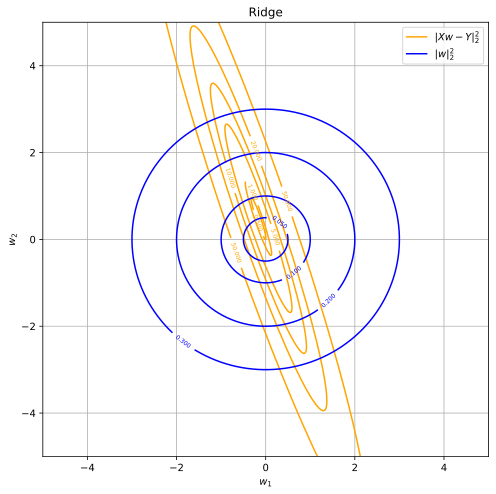

In [7]:
ax, fig = plt.subplots(figsize=(8,8))

def loss(w, X, Y):
    return 0.5/X.shape[0]*np.dot(X@w - Y, X@w - Y)

w1range = [-5, 5]
w2range = [-5, 5]
        
w1 = np.linspace(w1range[0], w1range[1], 500)
w2 = np.linspace(w2range[0], w2range[1], 500)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros(W1.shape)
P = np.zeros(W1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = loss(np.array([W1[i,j],W2[i,j]]), X, Y)
        P[i, j] = 0.1*np.linalg.norm(np.array([W1[i,j],W2[i,j]]))

CS1 = plt.contour(W1, W2, Z, levels=[0.1,0.2,0.5,1.,5,10,20,50], colors='orange')
plt.clabel(CS1, inline=1, fontsize=6) 

CS2 = plt.contour(W1, W2, P, levels=[0.05,0.1,0.2,0.3], colors='blue')
plt.clabel(CS2, inline=1, fontsize=6) 

plt.grid()  

plt.plot([],[], color='orange', label = '$\|Xw-Y\|^2_2$')
plt.plot([],[], color='blue', label = '$\|w\|^2_2$')
plt.xlim(w1range)
plt.ylim(w2range)

plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Ridge')

plt.legend()

# Lasso 

Lasso regression adds a penalty on the first norm of the coefficients vector:
$$\min_w \dfrac{1}{2N}\|Xw-Y\|^2_2 + \lambda\|w\|_1$$
As Ridge regression, Lasso prefers models with smaller coefficients and can make an ill-posed model well-posed. The most important property of Lasso is however that it induces **sparcity** of the coefficients. Indeed, Lasso solutions are typically located on the "corners" of the level sets of the first norm, which means that some of the coefficients in $w$ are zero.

Note that Lasso is not differentiable. However, in practice it is common to set $|x|'=sign(x)$ in gradient-based optimization methods to compute derivatives of functions with non-differentiable points.

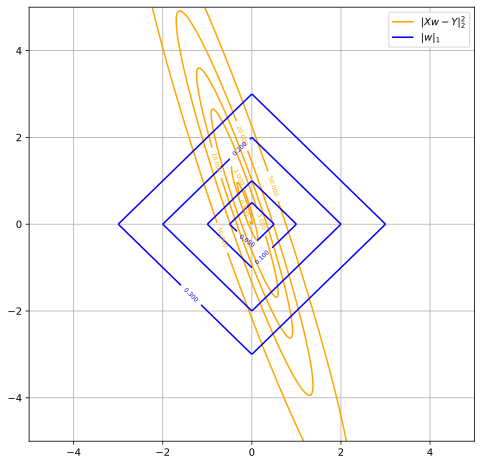

In [8]:
ax, fig = plt.subplots(figsize=(8,8))

def loss(w, X, Y):
    return 0.5/X.shape[0]*np.dot(X@w - Y, X@w - Y)

w1range = [-5, 5]
w2range = [-5, 5]
        
w1 = np.linspace(w1range[0], w1range[1], 500)
w2 = np.linspace(w2range[0], w2range[1], 500)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros(W1.shape)
P = np.zeros(W1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = loss(np.array([W1[i,j],W2[i,j]]), X, Y)
        P[i, j] = 0.1*np.linalg.norm(np.array([W1[i,j],W2[i,j]]),ord=1)

CS1 = plt.contour(W1, W2, Z, levels=[0.1,0.2,0.5,1.,5,10,20,50], colors='orange')
plt.clabel(CS1, inline=1, fontsize=6) 

CS2 = plt.contour(W1, W2, P, levels=[0.05,0.1,0.2,0.3], colors='blue')
plt.clabel(CS2, inline=1, fontsize=6) 

plt.grid()  

plt.plot([],[], color='orange', label = '$\|Xw-Y\|^2_2$')
plt.plot([],[], color='blue', label = '$\|w\|_1$')
plt.xlim(w1range)
plt.ylim(w2range)

plt.legend()

One more picture to see the difference between minimums found by Ridge and Lasso:

![Forms of the constraint regions for lasso and ridge regression.](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/2880px-L1_and_L2_balls.svg.png)
Source: https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/2880px-L1_and_L2_balls.svg.png

# Normalization

Another useful technique in ML is feature normalization. There are several common normalizations variants:

- **Standardization:** Assuming the distribution of the feature is Gaussian, standartization brings the distribution to standard Gaussian. $$\tilde{X}[:,j] = \dfrac{X[:,j] - \mu_j}{\sigma_j},$$ where $\mu_i = \dfrac{1}{N} \sum_i X[i,j]$ is the empirical mean and $\sigma_i^2 = \dfrac{1}{N-1} \sum_i (X[i,j]-\mu_j)^2$ is the empirical variance.
- **Min-max normalization:** Such normalization rescales the data so that the range of each feature is [0,1]: 
$$\tilde{X}[:,j] = \dfrac{X[:,j] - \min X[:,j]}{\max X[:,j] - \min X[:,j]}$$
- **Unit Vector Normalization:** This method shrinks each feature into a vector with norm one:
$$\tilde{X}[:,j] = \dfrac{X[:,j]}{\|X[:,j]\|}$$ Such normalization method is more commonly used to normalize data samples (i.e. rows of $X$).
 
Theoretically, feature normalization is just a linear transformation of $X$, which **does not effect properties of a linear regression/classification problem**. Indeed, solutions for the transformed $X$ can be obtained by corresponding linear transformations of the orginial problem solution $(w,b)$. However, normalization is important for **numerical properties** of the regression problem! To see why, let us again have a look at our dataset.

In [628]:
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.82,1.75,2.42,14.0,111,3.88,3.74,0.32,1.87,7.05,1.01,3.26,1190
1,-1,12.69,1.53,2.26,20.7,80,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495
2,1,14.22,3.99,2.51,13.2,128,3.00,3.04,0.20,2.08,5.10,0.89,3.53,760
3,-1,12.67,0.98,2.24,18.0,99,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450
4,1,13.30,1.72,2.14,17.0,94,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-1,12.42,1.61,2.19,22.5,108,2.00,2.09,0.34,1.61,2.06,1.06,2.96,345
126,-1,12.52,2.43,2.17,21.0,88,2.55,2.27,0.26,1.22,2.00,0.90,2.78,325
127,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
128,1,13.05,1.73,2.04,12.4,92,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150


We see that different columns (features) have very different ranges here. This means that coefficients of the same scale, corresponding to different features, result in very different changes in the output of a linear model.

In other words, the spectrum of $X^TX$ may include very different values. And one can show that the maximal feasible learning rate that guarantees convergence of GD is given by ${1}/{\lambda_{max}(X^TX)}$! Thus, without normalization, the maximal learning rate is determined by columns with the largest values. Such a learning rate is also likely to be to small to efficiently learn coefficients, corresponding to features with smaller vaules. 

Summing up:

- Normalization **imporives numerical stability of GD training**.
- Normalization can **spead up learning with GD**.

Thus, in practice it is often important to normalize features and/or data before running numerical optimization.

In [9]:
def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

X = normalize(df.iloc[:,df.columns != 'Class'].to_numpy())
Y = df.iloc[:,df.columns == 'Class'].to_numpy().reshape(-1)

train_X = normalize(train_df.iloc[:,df.columns != 'Class'].to_numpy())
train_Y = train_df.iloc[:,df.columns == 'Class'].to_numpy().reshape(-1)

test_X = normalize(test_df.iloc[:,df.columns != 'Class'].to_numpy())
test_Y = test_df.iloc[:,df.columns == 'Class'].to_numpy().reshape(-1)

# Ridge implementation

We implement Ridge classification as a **child class** of our LinearBinaryClassification class from the last session. Notice that many methods (including the GD training method LinearBinaryClassification.train() ) are inherited without changes.

In [10]:
class LinearBinaryClassification:

    def __init__(self, w, b):
        self._w = np.array(w, dtype=np.float)
        self._b = np.array(b, dtype=np.float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
    def h(self, x):
        return np.where(x @ self._w + self._b >= 0.0, 1, -1)
    
    def accuracy(self, X, Y):
        return 1. - np.sum(self.h(X) != Y)/Y.size
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0], ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]    
    
    def train(self, X, Y, lr = 1e-3, num_iter = 100):
        
        self.history[0]['loss'] = self.loss(X,Y)
        self.history[0]['accuracy'] = self.accuracy(X,Y)
        
        for e in range(num_iter):
            
            grad_w, grad_b = self.loss_grad(X,Y)
            self._w -= lr*grad_w
            self._b -= lr*grad_b
            
            self.history.append({'w': self._w.copy(),
                                 'b': self._b.copy(),
                                 'loss': self.loss(X,Y),
                                 'accuracy': self.accuracy(X,Y)})
            
        return self._w, self._b
    
    
class RidgeClassification(LinearBinaryClassification):
    
    def __init__(self, w, b, l):
        self._w = np.array(w, dtype=np.float)
        self._b = np.array(b, dtype=np.float)
        self.l = np.array(l, dtype=np.float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
    def MSE(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y) + self.l*np.dot(self._w,self._w)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0]+2*self.l*self._w, ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]    

Let us run the model and see how the regularization parameter $\lambda$ affects the solutions.

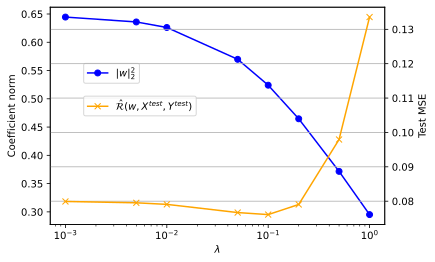

In [23]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

w = np.array([0]*X.shape[-1])
b = 0

ls = [0.001,0.005,0.01,0.05,0.1,0.2,0.5,1.]
w_norms = []
accuracies = []
losses = []
coefs = []

for l in ls:

    model = RidgeClassification(w, b, l=l)
    model.train(train_X,train_Y, lr = 1e-1, num_iter = 1000)
    
    accuracies.append(model.accuracy(train_X,train_Y))
    w_norms.append(np.linalg.norm(model._w))
    losses.append(model.MSE(test_X,test_Y))
    coefs.append(model._w)
    

ax.plot(ls, w_norms, color = 'blue', marker='o', label = '$\|w\|^2_2$')   
ax2.plot(ls, losses, color = 'orange', marker='x', label = '$\hat{\mathcal{R}}(w,X^{test},Y^{test})$')   
ax.set_xscale('log')
    
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Coefficient norm')
ax2.set_ylabel('Test MSE')
plt.grid()
ax.legend(loc=(0.1,0.65))
ax2.legend(loc=(0.1,0.5))

In [24]:
coefs = np.array(coefs)

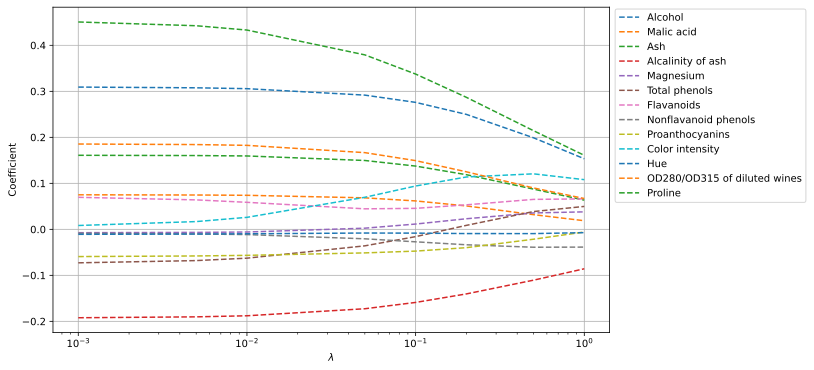

In [39]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(coefs.shape[1]):
    plt.plot(ls, coefs[:,i], ls='--', label=df.columns[i+1])

plt.legend(loc=(1.01,0.4))
plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('Coefficient')
plt.xscale('log')

# Cross-validation

How to choose the value of $\lambda$ hyperparameter? In practice, it is normally impossible to guess the best choice in advance. Therefore, multiple models with different hyperparametern values are trained and compared to find the hyperparameter values that give the best results. 

To compare multiple models, one needs to choose a **model validation** method. Before we were training a model on a training set and validating on the test subset, i.e. we used test error for validation. The generalization of this technique is **cross-validation (CV)**. In CV, we separate the dataset into $k$ parts $X = \sqcup X_k $ and train $k$ models with $X\setminus X_k$ as a training set. Then model $k$ is tested on $X_k$.

![cv](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png)
Source: https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png

Here we will use CV to compare models with different choices of $\lambda$ value.

In [12]:
def k_fold_split(X,Y,k):
    perm_ind = np.random.permutation(np.arange(X.shape[0]))
    return np.array_split(X[perm_ind],k), np.array_split(Y[perm_ind],k)

In [13]:
X_cv, Y_cv = k_fold_split(X,Y,k=5)

In [21]:
ls = [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1.]

mse_by_fold = []
for i in range(len(X_cv)):
    x_train = np.concatenate(X_cv[:i] + X_cv[i+1:])
    y_train = np.concatenate(Y_cv[:i] + Y_cv[i+1:])
    x_test = X_cv[i]
    y_test = Y_cv[i]
    
    mse_by_fold.append([]) 
    for l in ls:
        model = RidgeClassification(w, b, l=l)
        model.train(x_train,y_train, lr = 1e-3, num_iter = 1000)

        mse_by_fold[-1].append(model.MSE(x_test,y_test))

Best lambda value (CV estimate): 0.001


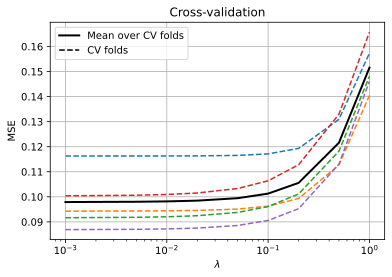

In [22]:
for i in range(len(X_cv)):
    plt.plot(ls,mse_by_fold[i],ls='--')

mean_cv_mse = np.mean(np.array(mse_by_fold),axis=0)
plt.plot(ls,mean_cv_mse , color='k', linewidth=2, label='Mean over CV folds')
plt.plot([],[],ls='--',color='k', label='CV folds')
plt.xscale('log')

plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Cross-validation')
plt.grid()
plt.legend()

best_l = ls[argmin(mean_cv_mse)]
print(f"Best lambda value (CV estimate): {best_l}")

# Exercise

Implement Lasso classifier as a new child class of LinearBinaryClassification. As mentioned before, you can assume that $\partial_w |w_i| = sign(w_i)$.